In [155]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(0)

In [156]:
# Parameters
n_realizations = 5
n = 100 # number of observations, length of beta_star 
D = n 
p_star = 5 # number of non-zero predictors
sigma = 1 # noise parameter

In [157]:
def generate_data(dim, pstar, a, sigma, nrep):
  """
  Parameters:
    int dim: The dimension of the dataset
    int pstar: The number of true non-zero signals
    real a: The magnitude of true non-zero signals
    real sigma: Standard deviation of the noise
    nrep: The number of replications
  """
  data = np.zeros((nrep, dim))                                # Initialise
  data[:,0:pstar] = data[:,0:pstar] + a               # Add signal
  data = data + np.random.normal(0, sigma, size=(nrep, dim))  # Add noise
  return data

<h2> Defining the Model </h2>

Horseshoe prior:

$$\begin{align*} y_i &\sim N(\beta_i, \sigma^2) \quad \text{for } i = 1,2,\ldots, n \\
\beta_i &\sim N(0, \tau^2 \lambda_i^2) \\
\lambda_i &\sim C^+(0, 1)
\end{align*}$$




We will compare two different hyperpriors for $\tau$: 

$\tau \sim C^+(0, 1)$ and $\tau = \tau_0 = \frac{p^*}{D-p^*}\sigma$.

In [158]:
def model(lam = 1/2, sigma = 1, y=None):
        '''
        Parameters:
                array y: dependent variable
                int sigma: stdev of y
                int lam: temperature coefficient
        '''
        D = y.shape
        alphas = numpyro.deterministic("alphas", jnp.ones(D))
        U = numpyro.sample("U", dist.Uniform(0, 1).expand(D))
        L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1-U))
        gammas = numpyro.deterministic("gammas", sigmoid(L + jnp.log(alphas) / lam))
        kappas = numpyro.deterministic("kappas", 1-gammas)
        numpyro.sample("y", dist.Normal(gammas, sigma), obs=y)

In [159]:
def run_mcmc(model, prng_key, y, **kwargs):
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=500, num_samples=1000)
    mcmc.run(prng_key, y=y, **kwargs)
    return mcmc

In [160]:
def concrete(all_data, nrep, dim, pstar):
    beta_samples = {}
    kappa_samples = []
    mean_sq_errors = [0]*11

    for A, y in all_data.items():
        beta_star = np.zeros(dim) 
        beta_star[:pstar] = beta_star[:pstar] + A
        mcmc = run_mcmc(model, prng_key, y, lam = 1/n_realizations)
        samples = mcmc.get_samples()
        mean_gammas = samples['gammas'].mean(axis=0) # mean across all samples
        mean_gammas = mean_gammas.mean(axis=0) # mean across all realizations
        
        estimated_betas = mean_gammas * beta_star
        mean_sq_errors[A] = jnp.mean((estimated_betas - beta_star)**2)
        beta_samples[A] = estimated_betas 
        kappa_samples.extend(samples['kappas'])
    
    return mean_sq_errors, kappa_samples, beta_samples

<h1> Run and Evaluate MCMC </h1>

In [161]:
all_mse_values = []
all_kappas = []

all_data = {}
A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
smaller_A_values = [4, 6]
for A in A_values:
    all_data[A] = generate_data(dim=D, pstar=p_star, a=A, sigma=1, nrep=n_realizations) 

mean_sq_errors, kappas, mean_betas = concrete(all_data, nrep=n_realizations, dim=D, pstar=p_star)


all_mse_values.append(mean_sq_errors)
all_kappas.extend(kappas)


all_mse_values = np.array(all_mse_values)
mean_mse_values = np.mean(all_mse_values, axis=0)

print(len(mean_betas), len(mean_betas[3]))


sample: 100%|██████████| 1500/1500 [00:01<00:00, 994.72it/s, 15 steps of size 2.85e-01. acc. prob=0.83] 


10 100


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [163]:
# for mcmc in all_mcmc_runs[:5]:
#     print(az.ess(mcmc))
#     print(az.rhat(mcmc))

<h1> Results </h1>

[Text(0.5, 0, 'Entry $i$')]

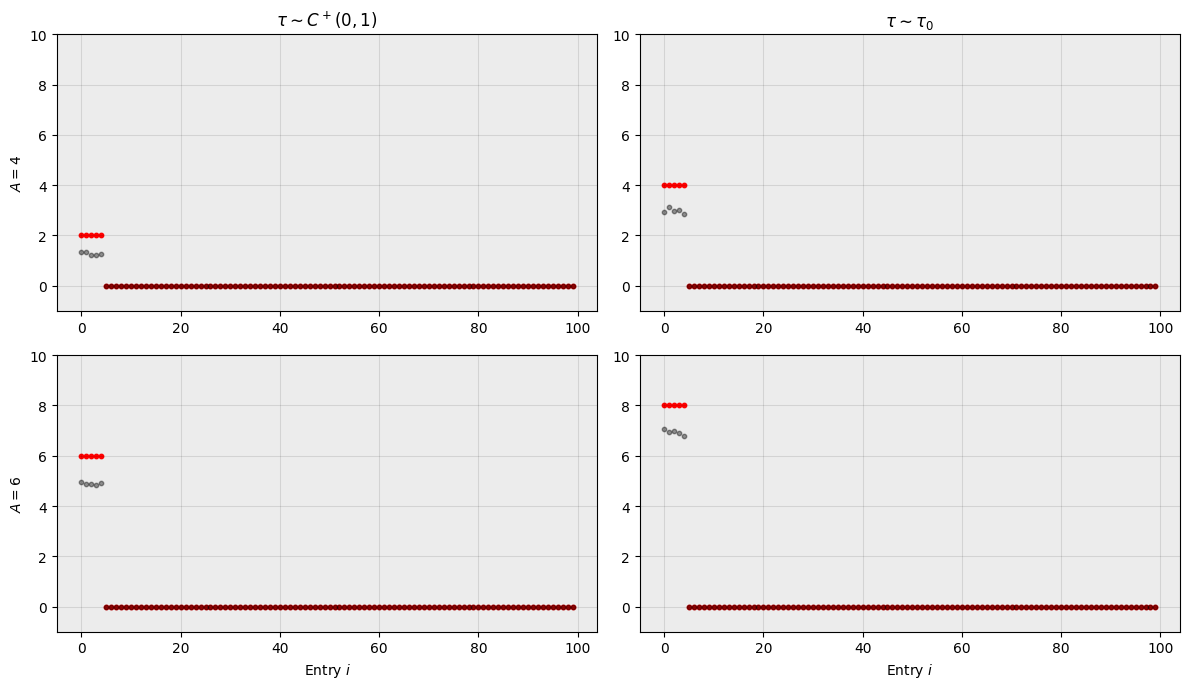

In [168]:
def plot_posterior_betas(beta_star, estimated_betas, ax):
    ax.scatter(range(D), beta_star, color='red', s=10) # plot actual betas
    ax.scatter(range(D), estimated_betas, color='black', s=10, alpha=0.4) # plot estimated betas
    # ax.scatter(range(len(y[i])), y[i], s=10, alpha=0.2, color='grey', marker='+') # plot y values


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), layout="tight")
for ax in [ax1, ax2, ax3, ax4]: 
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the graphs line up
ax2.set_ylim([-1, 10]) 
ax1.set_ylim([-1, 10])
ax4.set_ylim([-1, 10]) 
ax3.set_ylim([-1, 10])


beta_star_4 = np.zeros(n)
beta_star_4[:p_star] = 4
beta_star_6 = np.zeros(n)
beta_star_6[:p_star] = 6
beta_star_2 = np.zeros(n)
beta_star_2[:p_star] = 2
beta_star_8 = np.zeros(n)
beta_star_8[:p_star] = 8

plot_posterior_betas(beta_star_2, mean_betas[2], ax1)
plot_posterior_betas(beta_star_4, mean_betas[4], ax2)
plot_posterior_betas(beta_star_6, mean_betas[6], ax3)
plot_posterior_betas(beta_star_8, mean_betas[8], ax4)


# add labels to graph
ax1.set_title(r'$\tau \sim C^+(0, 1)$')
ax2.set_title(r'$\tau \sim \tau_0$')
ax1.set(ylabel=r'$A=4$')
ax3.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
ax4.set(xlabel=r'Entry $i$')


/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_27392/2961202336.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Mean Squared Error')

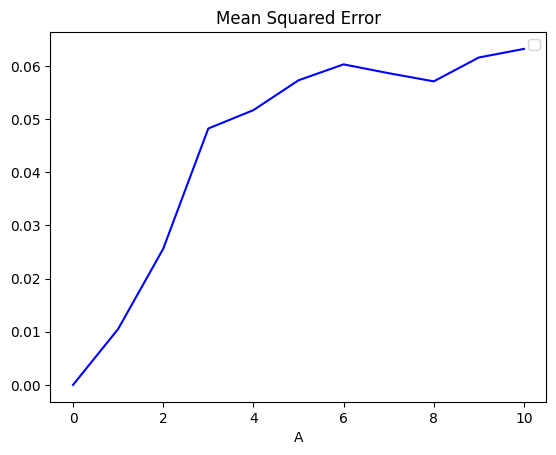

In [165]:
plt.plot(range(len(mean_mse_values)), mean_mse_values, "b", label=r'')
ax = plt.gca()
plt.legend()
plt.xlabel("A")
plt.title("Mean Squared Error")

<Axes: ylabel='Density'>

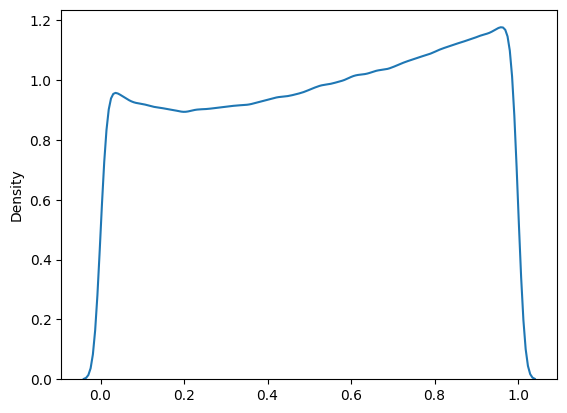

In [166]:
all_kappas = np.ndarray.flatten(np.array(all_kappas))
sns.kdeplot(all_kappas, legend=None)